In [2]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn as nn
import numpy as np

In [3]:
def generate_data(gpu_available, batch_size, n):
    if gpu_available:
        return [torch.randint(0, 2, (batch_size, n), dtype=torch.float).cuda()*2-1,
                torch.randint(0, 2, (batch_size, n), dtype=torch.float).cuda()*2-1,
                torch.randint(0, 2, (batch_size, n), dtype=torch.float).cuda()*2-1]
    else:
        return [torch.randint(0, 2, (batch_size, n), dtype=torch.float)*2-1,
                torch.randint(0, 2, (batch_size, n), dtype=torch.float)*2-1]
# end

In [4]:
class MixTransformNN(torch.nn.Module):
    def __init__(self, D_in, H):

        super(MixTransformNN, self).__init__()
        self.fc_layer = torch.nn.Linear(D_in, H)
        self.conv1 = torch.nn.Conv1d(in_channels=1,
                                     out_channels=2,
                                     kernel_size=4,
                                     stride=1,
                                     padding=2)
        self.conv2 = torch.nn.Conv1d(in_channels=2,
                                     out_channels=4,
                                     kernel_size=2,
                                     stride=2)
        self.conv3 = torch.nn.Conv1d(in_channels=4,
                                     out_channels=4,
                                     kernel_size=1,
                                     stride=1)
        self.conv4 = torch.nn.Conv1d(in_channels=4,
                                     out_channels=1,
                                     kernel_size=1,
                                     stride=1)


    def forward(self, x):

        x = x[None, :, :].transpose(0, 1)

        x = torch.sigmoid(self.fc_layer(x))

        x = torch.sigmoid(self.conv1(x))

        x = torch.sigmoid(self.conv2(x))

        x = torch.sigmoid(self.conv3(x))

        x = torch.tanh(self.conv4(x))

        return torch.squeeze(x)

In [5]:
batch_size = 256
n = 16
learning_rate = 0.0008
training_steps = 15000
gpu_available = True
show_every_n_steps = 100
aggregated_losses_every_n_steps = 100
clip_value = 1

alice = MixTransformNN(D_in=(n*2), H=(n*2))
bob = MixTransformNN(D_in=(n*2), H=(n*2))
eve = MixTransformNN(D_in=(n), H=(n*2))

alice.train()
bob.train()
eve.train()
alice.cuda()
bob.cuda()
eve.cuda()

aggregated_losses = {
            "alice_bob_training_loss": [],
            "bob_reconstruction_training_errors": [],
            "eve_reconstruction_training_errors": [],
            "step": []
}

optimizer_alice = Adam(params=alice.parameters(), lr=learning_rate)
optimizer_bob = Adam(params=bob.parameters(), lr=learning_rate)
optimizer_eve = Adam(params=eve.parameters(), lr=learning_rate)

bob_reconstruction_error = nn.L1Loss()
eve_reconstruction_error = nn.L1Loss()

for step in range(training_steps+1):

    # Training alternates between Alice/Bob and Eve
    for network, num_minibatches in {"alice_bob": 1, "eve": 2}.items():

        """ 
        Alice/Bob training for one minibatch, and then Eve training for two minibatches this ratio 
        in order to give a slight computational edge to the adversary Eve without training it so much
        that it becomes excessively specific to the exact current parameters of Alice and Bob
        """
        for minibatch in range(num_minibatches):

            p, ka, kb = generate_data(gpu_available=True, batch_size=batch_size, n=n)

            # forward pass through alice and eve networks
            alice_c = alice.forward(torch.cat((p, ka), 1).float())
            eve_p = eve.forward(alice_c)

            if network == "alice_bob":

                # forward pass through bob network
                bob_p = bob.forward(torch.cat((alice_c, ka), 1).float())

                # calculate errors
                error_bob = bob_reconstruction_error(input=bob_p, target=p)
                error_eve = eve_reconstruction_error(input=eve_p, target=p)
                alice_bob_loss =  error_bob + (1.0 - error_eve**2)

                # Zero gradients, perform a backward pass, clip gradients, and update the weights.
                optimizer_alice.zero_grad()
                optimizer_bob.zero_grad()
                alice_bob_loss.backward()
                nn.utils.clip_grad_value_(alice.parameters(), clip_value)
                nn.utils.clip_grad_value_(bob.parameters(), clip_value)
                optimizer_alice.step()
                optimizer_bob.step()

            elif network == "eve":

                # calculate error
                error_eve = eve_reconstruction_error(input=eve_p, target=p)

                # Zero gradients, perform a backward pass, and update the weights
                optimizer_eve.zero_grad()
                error_eve.backward()
                nn.utils.clip_grad_value_(eve.parameters(), clip_value)
                optimizer_eve.step()


    if step % aggregated_losses_every_n_steps == 0:
        # aggregate min training errors for bob and eve networks
        aggregated_losses["alice_bob_training_loss"].append(alice_bob_loss.cpu().detach().numpy().tolist())
        aggregated_losses["bob_reconstruction_training_errors"].append(error_bob.cpu().detach().numpy().tolist())
        aggregated_losses["eve_reconstruction_training_errors"].append(error_eve.cpu().detach().numpy().tolist())
        aggregated_losses["step"].append(step)

    if step % show_every_n_steps == 0:
        print("Total_Steps: %i of %i || Bob_Alice_Loss: %.5f || Bob_Reconstruction_Error: %.5f || Eve_Reconstruction_Error: %.5f" % (step, training_steps, 
                                                                                                                                     aggregated_losses["alice_bob_training_loss"][-1], 
                                                                                                                                     aggregated_losses["bob_reconstruction_training_errors"][-1], 
                                                                                                                                     aggregated_losses["eve_reconstruction_training_errors"][-1]))

Total_Steps: 0 of 15000 || Bob_Alice_Loss: 1.00562 || Bob_Reconstruction_Error: 1.00139 || Eve_Reconstruction_Error: 0.99640
Total_Steps: 100 of 15000 || Bob_Alice_Loss: 0.99669 || Bob_Reconstruction_Error: 0.99923 || Eve_Reconstruction_Error: 0.99874
Total_Steps: 200 of 15000 || Bob_Alice_Loss: 1.00069 || Bob_Reconstruction_Error: 1.00027 || Eve_Reconstruction_Error: 1.00074
Total_Steps: 300 of 15000 || Bob_Alice_Loss: 1.00060 || Bob_Reconstruction_Error: 1.00037 || Eve_Reconstruction_Error: 1.00016
Total_Steps: 400 of 15000 || Bob_Alice_Loss: 1.00062 || Bob_Reconstruction_Error: 1.00085 || Eve_Reconstruction_Error: 0.99977
Total_Steps: 500 of 15000 || Bob_Alice_Loss: 0.99982 || Bob_Reconstruction_Error: 0.99992 || Eve_Reconstruction_Error: 0.99954
Total_Steps: 600 of 15000 || Bob_Alice_Loss: 1.00011 || Bob_Reconstruction_Error: 1.00002 || Eve_Reconstruction_Error: 0.99824
Total_Steps: 700 of 15000 || Bob_Alice_Loss: 0.99624 || Bob_Reconstruction_Error: 0.99887 || Eve_Reconstruction_E

Total_Steps: 6500 of 15000 || Bob_Alice_Loss: 1.02046 || Bob_Reconstruction_Error: 0.99401 || Eve_Reconstruction_Error: 1.00194
Total_Steps: 6600 of 15000 || Bob_Alice_Loss: 0.98802 || Bob_Reconstruction_Error: 1.00372 || Eve_Reconstruction_Error: 0.99556
Total_Steps: 6700 of 15000 || Bob_Alice_Loss: 1.01037 || Bob_Reconstruction_Error: 0.99662 || Eve_Reconstruction_Error: 1.00085
Total_Steps: 6800 of 15000 || Bob_Alice_Loss: 1.00272 || Bob_Reconstruction_Error: 0.99926 || Eve_Reconstruction_Error: 0.99564
Total_Steps: 6900 of 15000 || Bob_Alice_Loss: 1.00658 || Bob_Reconstruction_Error: 0.99822 || Eve_Reconstruction_Error: 0.99862
Total_Steps: 7000 of 15000 || Bob_Alice_Loss: 0.98916 || Bob_Reconstruction_Error: 1.00207 || Eve_Reconstruction_Error: 0.99239
Total_Steps: 7100 of 15000 || Bob_Alice_Loss: 0.99181 || Bob_Reconstruction_Error: 1.00145 || Eve_Reconstruction_Error: 1.00232
Total_Steps: 7200 of 15000 || Bob_Alice_Loss: 0.98355 || Bob_Reconstruction_Error: 1.00137 || Eve_Recons

Total_Steps: 12900 of 15000 || Bob_Alice_Loss: 1.03103 || Bob_Reconstruction_Error: 1.01273 || Eve_Reconstruction_Error: 1.00918
Total_Steps: 13000 of 15000 || Bob_Alice_Loss: 0.99718 || Bob_Reconstruction_Error: 0.99998 || Eve_Reconstruction_Error: 0.99811
Total_Steps: 13100 of 15000 || Bob_Alice_Loss: 1.01808 || Bob_Reconstruction_Error: 1.05889 || Eve_Reconstruction_Error: 1.00752
Total_Steps: 13200 of 15000 || Bob_Alice_Loss: 1.04092 || Bob_Reconstruction_Error: 1.01774 || Eve_Reconstruction_Error: 0.97120
Total_Steps: 13300 of 15000 || Bob_Alice_Loss: 0.98102 || Bob_Reconstruction_Error: 0.99423 || Eve_Reconstruction_Error: 1.01630
Total_Steps: 13400 of 15000 || Bob_Alice_Loss: 1.00780 || Bob_Reconstruction_Error: 0.99899 || Eve_Reconstruction_Error: 0.99959
Total_Steps: 13500 of 15000 || Bob_Alice_Loss: 0.98828 || Bob_Reconstruction_Error: 0.98926 || Eve_Reconstruction_Error: 0.97661
Total_Steps: 13600 of 15000 || Bob_Alice_Loss: 1.03298 || Bob_Reconstruction_Error: 1.00640 || Ev

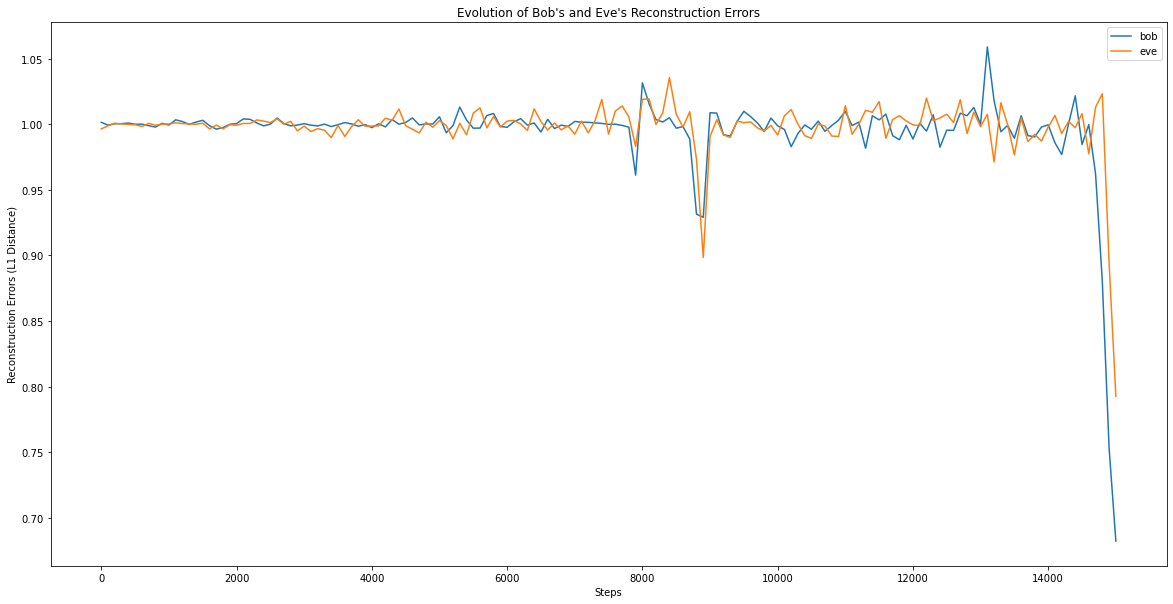

In [6]:

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(aggregated_losses["step"], aggregated_losses["bob_reconstruction_training_errors"], label="bob")
ax.plot(aggregated_losses["step"], aggregated_losses["eve_reconstruction_training_errors"], label="eve")
ax.legend()
ax.set_title("Evolution of Bob's and Eve's Reconstruction Errors")
ax.set_xlabel("Steps")
ax.set_ylabel("Reconstruction Errors (L1 Distance)")

plt.show()

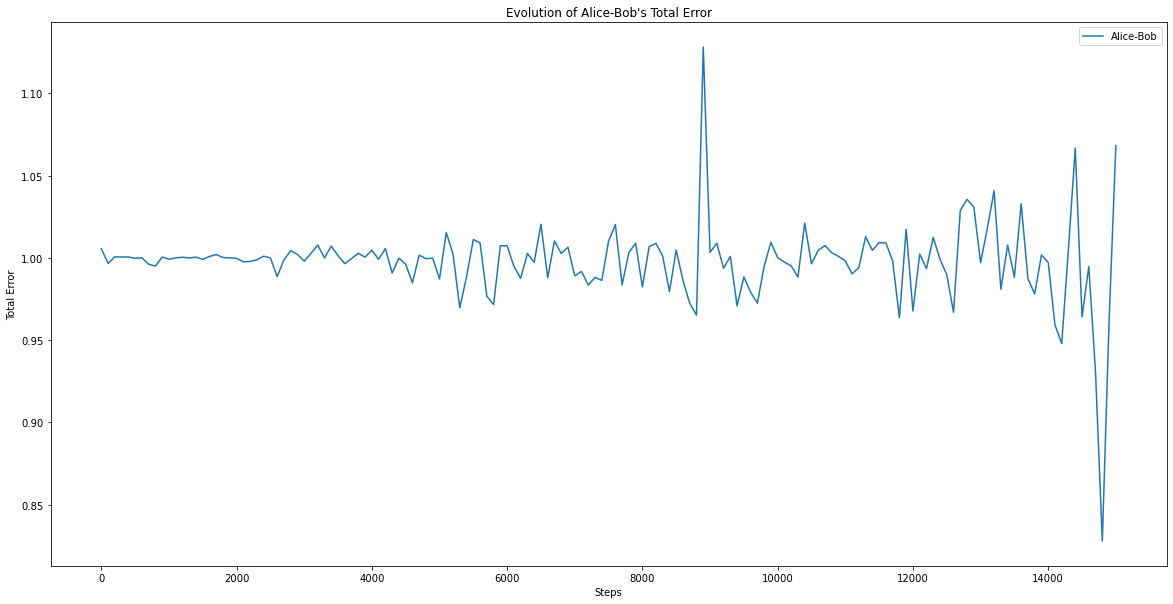

In [7]:

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(aggregated_losses["step"], aggregated_losses["alice_bob_training_loss"], label="Alice-Bob")
ax.legend()
ax.set_title("Evolution of Alice-Bob's Total Error")
ax.set_xlabel("Steps")
ax.set_ylabel("Total Error")

plt.show()

In [8]:
batch_size = 256
n = 16
learning_rate = 0.0008
training_steps = 15000
gpu_available = True
show_every_n_steps = 100
aggregated_losses_every_n_steps = 100
clip_value = 1

alice = MixTransformNN(D_in=(n*2), H=(n*2))
bob = MixTransformNN(D_in=(n*2), H=(n*2))
eve = MixTransformNN(D_in=(n), H=(n*2))

alice.train()
bob.train()
eve.train()
alice.cuda()
bob.cuda()
eve.cuda()

aggregated_losses = {
            "alice_bob_training_loss": [],
            "bob_reconstruction_training_errors": [],
            "eve_reconstruction_training_errors": [],
            "step": []
}

optimizer_alice = Adam(params=alice.parameters(), lr=learning_rate)
optimizer_bob = Adam(params=bob.parameters(), lr=learning_rate)
optimizer_eve = Adam(params=eve.parameters(), lr=learning_rate)

bob_reconstruction_error = nn.L1Loss()
eve_reconstruction_error = nn.L1Loss()

for step in range(training_steps+1):

    # Training alternates between Alice/Bob and Eve
    for network, num_minibatches in {"alice_bob": 2, "eve": 1}.items():

        """ 
        Alice/Bob training for one minibatch, and then Eve training for two minibatches this ratio 
        in order to give a slight computational edge to the adversary Eve without training it so much
        that it becomes excessively specific to the exact current parameters of Alice and Bob
        """
        for minibatch in range(num_minibatches):

            p, ka, kb = generate_data(gpu_available=True, batch_size=batch_size, n=n)

            # forward pass through alice and eve networks
            alice_c = alice.forward(torch.cat((p, ka), 1).float())
            eve_p = eve.forward(alice_c)

            if network == "alice_bob":

                # forward pass through bob network
                bob_p = bob.forward(torch.cat((alice_c, ka), 1).float())

                # calculate errors
                error_bob = bob_reconstruction_error(input=bob_p, target=p)
                error_eve = eve_reconstruction_error(input=eve_p, target=p)
                alice_bob_loss =  error_bob + (1.0 - error_eve**2)

                # Zero gradients, perform a backward pass, clip gradients, and update the weights.
                optimizer_alice.zero_grad()
                optimizer_bob.zero_grad()
                alice_bob_loss.backward()
                nn.utils.clip_grad_value_(alice.parameters(), clip_value)
                nn.utils.clip_grad_value_(bob.parameters(), clip_value)
                optimizer_alice.step()
                optimizer_bob.step()

            elif network == "eve":

                # calculate error
                error_eve = eve_reconstruction_error(input=eve_p, target=p)

                # Zero gradients, perform a backward pass, and update the weights
                optimizer_eve.zero_grad()
                error_eve.backward()
                nn.utils.clip_grad_value_(eve.parameters(), clip_value)
                optimizer_eve.step()


    if step % aggregated_losses_every_n_steps == 0:
        # aggregate min training errors for bob and eve networks
        aggregated_losses["alice_bob_training_loss"].append(alice_bob_loss.cpu().detach().numpy().tolist())
        aggregated_losses["bob_reconstruction_training_errors"].append(error_bob.cpu().detach().numpy().tolist())
        aggregated_losses["eve_reconstruction_training_errors"].append(error_eve.cpu().detach().numpy().tolist())
        aggregated_losses["step"].append(step)

    if step % show_every_n_steps == 0:
        print("Total_Steps: %i of %i || Bob_Alice_Loss: %.5f || Bob_Reconstruction_Error: %.5f || Eve_Reconstruction_Error: %.5f" % (step, training_steps, 
                                                                                                                                     aggregated_losses["alice_bob_training_loss"][-1], 
                                                                                                                                     aggregated_losses["bob_reconstruction_training_errors"][-1], 
                                                                                                                                aggregated_losses["eve_reconstruction_training_errors"][-1]))
        
        

    

Total_Steps: 0 of 15000 || Bob_Alice_Loss: 1.01643 || Bob_Reconstruction_Error: 1.00637 || Eve_Reconstruction_Error: 1.00473
Total_Steps: 100 of 15000 || Bob_Alice_Loss: 1.01294 || Bob_Reconstruction_Error: 1.00449 || Eve_Reconstruction_Error: 0.99886
Total_Steps: 200 of 15000 || Bob_Alice_Loss: 1.01141 || Bob_Reconstruction_Error: 1.00425 || Eve_Reconstruction_Error: 0.99266
Total_Steps: 300 of 15000 || Bob_Alice_Loss: 1.01088 || Bob_Reconstruction_Error: 1.00357 || Eve_Reconstruction_Error: 1.00267
Total_Steps: 400 of 15000 || Bob_Alice_Loss: 1.01105 || Bob_Reconstruction_Error: 1.00206 || Eve_Reconstruction_Error: 0.99816
Total_Steps: 500 of 15000 || Bob_Alice_Loss: 0.80068 || Bob_Reconstruction_Error: 0.81078 || Eve_Reconstruction_Error: 1.00517
Total_Steps: 600 of 15000 || Bob_Alice_Loss: 0.32906 || Bob_Reconstruction_Error: 0.32335 || Eve_Reconstruction_Error: 0.99372
Total_Steps: 700 of 15000 || Bob_Alice_Loss: 0.16178 || Bob_Reconstruction_Error: 0.12393 || Eve_Reconstruction_E

Total_Steps: 6500 of 15000 || Bob_Alice_Loss: 0.10807 || Bob_Reconstruction_Error: 0.01016 || Eve_Reconstruction_Error: 0.98294
Total_Steps: 6600 of 15000 || Bob_Alice_Loss: 0.09097 || Bob_Reconstruction_Error: 0.00822 || Eve_Reconstruction_Error: 0.97739
Total_Steps: 6700 of 15000 || Bob_Alice_Loss: 0.09730 || Bob_Reconstruction_Error: 0.00917 || Eve_Reconstruction_Error: 0.97013
Total_Steps: 6800 of 15000 || Bob_Alice_Loss: 0.07864 || Bob_Reconstruction_Error: 0.00799 || Eve_Reconstruction_Error: 0.98849
Total_Steps: 6900 of 15000 || Bob_Alice_Loss: 0.08848 || Bob_Reconstruction_Error: 0.02579 || Eve_Reconstruction_Error: 0.97311
Total_Steps: 7000 of 15000 || Bob_Alice_Loss: 0.07328 || Bob_Reconstruction_Error: 0.00987 || Eve_Reconstruction_Error: 0.97011
Total_Steps: 7100 of 15000 || Bob_Alice_Loss: 0.08365 || Bob_Reconstruction_Error: 0.01677 || Eve_Reconstruction_Error: 0.95118
Total_Steps: 7200 of 15000 || Bob_Alice_Loss: 0.09972 || Bob_Reconstruction_Error: 0.01222 || Eve_Recons

Total_Steps: 12900 of 15000 || Bob_Alice_Loss: 0.03766 || Bob_Reconstruction_Error: 0.00637 || Eve_Reconstruction_Error: 0.96996
Total_Steps: 13000 of 15000 || Bob_Alice_Loss: 0.08765 || Bob_Reconstruction_Error: 0.00818 || Eve_Reconstruction_Error: 0.96559
Total_Steps: 13100 of 15000 || Bob_Alice_Loss: 0.09596 || Bob_Reconstruction_Error: 0.02839 || Eve_Reconstruction_Error: 0.98226
Total_Steps: 13200 of 15000 || Bob_Alice_Loss: 0.08230 || Bob_Reconstruction_Error: 0.01069 || Eve_Reconstruction_Error: 0.96587
Total_Steps: 13300 of 15000 || Bob_Alice_Loss: 0.06469 || Bob_Reconstruction_Error: 0.00868 || Eve_Reconstruction_Error: 0.98248
Total_Steps: 13400 of 15000 || Bob_Alice_Loss: 0.08743 || Bob_Reconstruction_Error: 0.01029 || Eve_Reconstruction_Error: 0.95980
Total_Steps: 13500 of 15000 || Bob_Alice_Loss: 0.06518 || Bob_Reconstruction_Error: 0.00657 || Eve_Reconstruction_Error: 0.98031
Total_Steps: 13600 of 15000 || Bob_Alice_Loss: 0.09014 || Bob_Reconstruction_Error: 0.00616 || Ev

In [9]:
print("Final plaintext:\n")
plain = p.data.cpu().numpy()
bob_plain = bob_p.data.cpu().numpy()
for j in range (0, 5):
    for i in range (0, 16):
        print("plain:", plain[j][i], " bob:", round(bob_plain[j][i]))
    print("BREAK")

Final plaintext:

plain: -1.0  bob: 1.0
plain: -1.0  bob: -1.0
plain: -1.0  bob: -1.0
plain: -1.0  bob: -1.0
plain: 1.0  bob: 1.0
plain: -1.0  bob: -1.0
plain: 1.0  bob: -1.0
plain: 1.0  bob: 1.0
plain: -1.0  bob: 1.0
plain: 1.0  bob: 1.0
plain: -1.0  bob: 1.0
plain: 1.0  bob: 1.0
plain: 1.0  bob: -1.0
plain: -1.0  bob: 1.0
plain: -1.0  bob: 1.0
plain: -1.0  bob: 1.0
BREAK
plain: -1.0  bob: 1.0
plain: 1.0  bob: 1.0
plain: -1.0  bob: 1.0
plain: -1.0  bob: 1.0
plain: 1.0  bob: -1.0
plain: -1.0  bob: 1.0
plain: 1.0  bob: -1.0
plain: -1.0  bob: 1.0
plain: 1.0  bob: 1.0
plain: -1.0  bob: 1.0
plain: -1.0  bob: -1.0
plain: -1.0  bob: -1.0
plain: 1.0  bob: 1.0
plain: 1.0  bob: -1.0
plain: 1.0  bob: -1.0
plain: 1.0  bob: 1.0
BREAK
plain: 1.0  bob: 1.0
plain: 1.0  bob: 1.0
plain: -1.0  bob: 1.0
plain: 1.0  bob: -1.0
plain: 1.0  bob: -1.0
plain: -1.0  bob: -1.0
plain: -1.0  bob: -1.0
plain: -1.0  bob: 1.0
plain: 1.0  bob: 1.0
plain: -1.0  bob: 1.0
plain: -1.0  bob: -1.0
plain: 1.0  bob: 1.0
plain

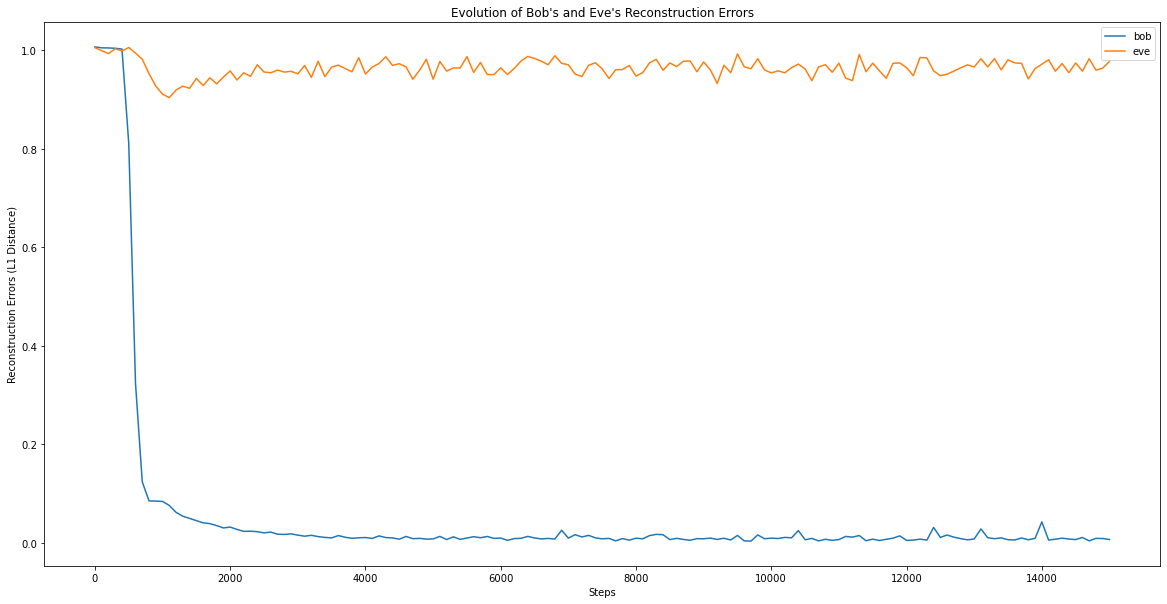

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(aggregated_losses["step"], aggregated_losses["bob_reconstruction_training_errors"], label="bob")
ax.plot(aggregated_losses["step"], aggregated_losses["eve_reconstruction_training_errors"], label="eve")
ax.legend()
ax.set_title("Evolution of Bob's and Eve's Reconstruction Errors")
ax.set_xlabel("Steps")
ax.set_ylabel("Reconstruction Errors (L1 Distance)")

plt.show()

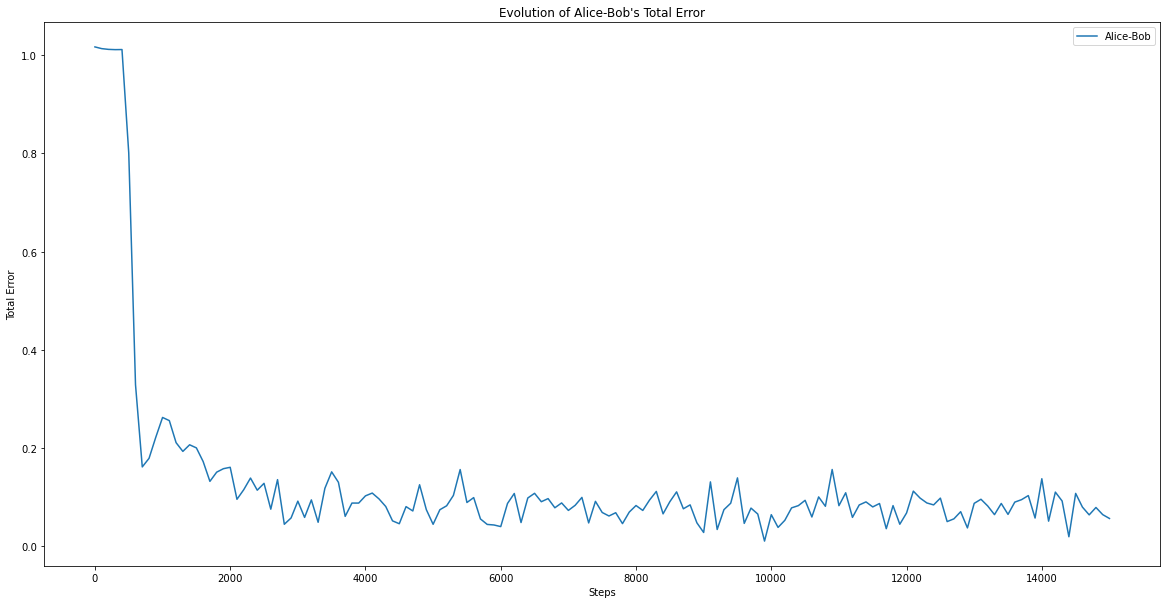

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(aggregated_losses["step"], aggregated_losses["alice_bob_training_loss"], label="Alice-Bob")
ax.legend()
ax.set_title("Evolution of Alice-Bob's Total Error")
ax.set_xlabel("Steps")
ax.set_ylabel("Total Error")

plt.show()

In [12]:
class KeyNN(torch.nn.Module):
    def __init__(self):

        super(KeyNN, self).__init__()
        self.fc1 = torch.nn.Linear(4, 4)
        self.fc2 = torch.nn.Linear(4, 1)
        
        

    def forward(self, x):

        x = x[None, :, :].transpose(0, 1)

        x = torch.sigmoid(self.fc1(x))

        x = torch.tanh(self.fc2(x))

        return torch.squeeze(x)

In [154]:
def equals(in1, in2):
    return 1 if in1 == in2 else 0

class TreeParityMachine:
    def __init__(self, hidden_neur=3, input_size=4, weight_range=6):
        self.hidden_neur = hidden_neur
        self.input_size = input_size
        self.weight_range = weight_range
        self.weights = np.random.randint(-weight_range, weight_range + 1, [hidden_neur, input_size])
        
    def get_output(self, input_vector):
        hidden_neur = self.hidden_neur
        input_size = self.input_size
        weights = self.weights
        
        input_vector = input_vector.reshape([hidden_neur, input_size])
        
        sigma = np.sign(np.sum(input_vector * weights, axis=1))
        tau = np.prod(sigma)
        
        self.input_vector = input_vector
        self.sigma = sigma
        self.tau = tau
                
        return tau
    
    def update(self, tau2):
        tau1 = self.tau
        k, n = self.weights.shape
        for (i, j), _ in np.ndenumerate(self.weights):
            self.weights[i,j] += self.input_vector[i,j] * equals(self.sigma[i], tau1) * equals(tau1, tau2)
            self.weights[i,j] = np.clip(self.weights[i,j], -self.weight_range, self.weight_range)
                    

score: 16  update: 1
score: 18  update: 2
score: 18  update: 3
score: 15  update: 4
score: 15  update: 5
score: 15  update: 6
score: 17  update: 7
score: 13  update: 8
score: 13  update: 9
score: 13  update: 10
score: 13  update: 11
score: 13  update: 12
score: 12  update: 13
score: 17  update: 14
score: 16  update: 15
score: 16  update: 16
score: 14  update: 17
score: 14  update: 18
score: 14  update: 19
score: 13  update: 20
score: 13  update: 21
score: 13  update: 22
score: 14  update: 23
score: 14  update: 24
score: 14  update: 25
score: 14  update: 26
score: 16  update: 27
score: 16  update: 28
score: 16  update: 29
score: 15  update: 30
score: 15  update: 31
score: 12  update: 32
score: 12  update: 33
score: 12  update: 34
score: 12  update: 35
score: 12  update: 36
score: 12  update: 37
score: 12  update: 38
score: 12  update: 39
score: 16  update: 40
score: 12  update: 41
score: 12  update: 42
score: 12  update: 43
score: 12  update: 44
score: 11  update: 45
score: 13  update: 

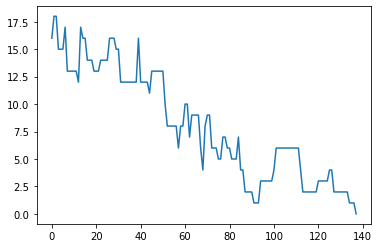

In [71]:
h = 4
i = 4
wr = 1

alice = TreeParityMachine(h, i, wr)
bob = TreeParityMachine(h,i,wr)

def random():
    return np.random.randint(-wr, wr + 1, [h, i])

def weight_diff(in1, in2):
    #return 1.0 - np.average(1.0 * np.abs(in1.weights, in2.weights)/(2*wr))
    return np.sum(np.abs(in1.weights - in2.weights))

equal = False
update_count = 0
diffs = []
 
while (not equal):
    
    rand_in = random()
    tau_alice = alice.get_output(rand_in)
    tau_bob = bob.get_output(rand_in)
    
    alice.update(tau_bob)
    bob.update(tau_alice)
    
    update_count += 1
     
    step_score = weight_diff(alice, bob)
    diffs.append(step_score)
    print("score:", step_score, " update:", update_count)
    
    if (step_score == 0):
        equal = True
        print("A:", alice.weights)
        print("B:", bob.weights)
        
import matplotlib.pyplot as mpl
mpl.plot(diffs)
mpl.show()        

In [68]:
learning_rate = 0.0008
total_steps = 10000
aggregated_losses_every_n_steps = 100
show_every_n_steps = 10
clip_value = 1


key1 = KeyNN()
key1.train()
key1.cuda()
print(key1.fc1.weight)
key1_optimizer = Adam(params=key1.parameters(), lr=learning_rate)
key1_error = nn.L1Loss()

key2 = KeyNN()
key2.train()
key2.cuda()
print(key2.fc1.weight)
key2_optimizer = Adam(params=key2.parameters(), lr=learning_rate)
key2_error = nn.L1Loss()

def weight_diff():
    total = 0
    for i in range (0, 4):
        for ii in range (0, 4):
            total += abs(key1.fc1.weight[i][ii].data.cpu().numpy() - key2.fc1.weight[i][ii].data.cpu().numpy())
    return (total)

losses = {
            "key1_error": [],
            "key2_error": [],
            "weight_diff": [],
            "step": []
}

step = 0
#while ((w = weight_diff()) > 1):
for step in range (total_steps + 1):
    input = torch.randint(0, 2, (1, 4), dtype=torch.float).cuda()*2-1
    # forward pass through bob network
    key1_out = key1.forward(input.float())
    key2_out = key2.forward(input.float())
    
    print ("1 out: %.5f 2 out: %.5f" % (key1_out, key2_out))

    # calculate errors
    key1_err = key1_error(input=key1_out, target=key2_out)
    key2_err = key2_error(input=key2_out, target=key1_out)

    # Zero gradients, perform a backward pass, clip gradients, and update the weights.
    key1_optimizer.zero_grad()
    key2_optimizer.zero_grad()
    key1_err.backward(retain_graph=True)
    key2_err.backward(retain_graph=True)
    nn.utils.clip_grad_value_(key1.parameters(), clip_value)
    nn.utils.clip_grad_value_(key2.parameters(), clip_value)
    key1_optimizer.step()
    key2_optimizer.step()
    
    if step % aggregated_losses_every_n_steps == 0:
        losses["weight_diff"].append(weight_diff())
        losses["key1_error"].append(key1_err.cpu().detach().numpy().tolist())
        losses["key2_error"].append(key2_err.cpu().detach().numpy().tolist())
        losses["step"].append(step)
        
    if step % show_every_n_steps == 0:
        print("Total_Steps: %i of %i || Key1_Error: %.5f || key2_Error: %.5f || weight_diff: %.5f" % (step, total_steps, losses["key1_error"][-1], losses["key2_error"][-1], losses["weight_diff"][-1]))
    
    
    

Parameter containing:
tensor([[ 0.4802,  0.2530,  0.2341,  0.2252],
        [-0.0069,  0.2213,  0.3561, -0.0189],
        [-0.4976,  0.1939,  0.0059,  0.3678],
        [ 0.4963,  0.3240,  0.2637,  0.3972]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.2679,  0.2240,  0.2091,  0.2358],
        [-0.2778,  0.0091, -0.0877,  0.2127],
        [-0.0683, -0.3936, -0.2676, -0.0090],
        [ 0.1364, -0.2973, -0.0373, -0.3814]], device='cuda:0',
       requires_grad=True)
1 out: -0.48059 2 out: 0.05040
Total_Steps: 0 of 10000 || Key1_Error: 0.53099 || key2_Error: 0.53099 || weight_diff: 5.70240
1 out: -0.42248 2 out: -0.09516
1 out: -0.59338 2 out: 0.12699
1 out: -0.59158 2 out: 0.12477
1 out: -0.47298 2 out: 0.03957
1 out: -0.49615 2 out: -0.00041
1 out: -0.42103 2 out: -0.02586
1 out: -0.52197 2 out: 0.09554
1 out: -0.46511 2 out: -0.06083
1 out: -0.51265 2 out: -0.00162
1 out: -0.56554 2 out: 0.15162
Total_Steps: 10 of 10000 || Key1_Error: 0.53099 || key2_Er

1 out: -0.24733 2 out: -0.16098
1 out: -0.20671 2 out: -0.27675
Total_Steps: 240 of 10000 || Key1_Error: 0.00434 || key2_Error: 0.00434 || weight_diff: 5.56647
1 out: -0.27027 2 out: -0.18915
1 out: -0.24728 2 out: -0.16094
1 out: -0.24685 2 out: -0.16133
1 out: -0.22868 2 out: -0.30446
1 out: -0.20650 2 out: -0.27651
1 out: -0.22738 2 out: -0.22433
1 out: -0.20644 2 out: -0.27654
1 out: -0.30492 2 out: -0.07689
1 out: -0.20604 2 out: -0.27668
1 out: -0.26416 2 out: -0.19464
Total_Steps: 250 of 10000 || Key1_Error: 0.00434 || key2_Error: 0.00434 || weight_diff: 5.56647
1 out: -0.20639 2 out: -0.27633
1 out: -0.19167 2 out: -0.33371
1 out: -0.24418 2 out: -0.16362
1 out: -0.19024 2 out: -0.32428
1 out: -0.28594 2 out: -0.14110
1 out: -0.17205 2 out: -0.37345
1 out: -0.25032 2 out: -0.25246
1 out: -0.27564 2 out: -0.13428
1 out: -0.22427 2 out: -0.22008
1 out: -0.20760 2 out: -0.27439
Total_Steps: 260 of 10000 || Key1_Error: 0.00434 || key2_Error: 0.00434 || weight_diff: 5.56647
1 out: -

1 out: -0.20621 2 out: -0.22145
Total_Steps: 480 of 10000 || Key1_Error: 0.09201 || key2_Error: 0.09201 || weight_diff: 5.13348
1 out: -0.23482 2 out: -0.27761
1 out: -0.24207 2 out: -0.24213
1 out: -0.24255 2 out: -0.24151
1 out: -0.21058 2 out: -0.25217
1 out: -0.20787 2 out: -0.28799
1 out: -0.21792 2 out: -0.21454
1 out: -0.24336 2 out: -0.20410
1 out: -0.24034 2 out: -0.16802
1 out: -0.20443 2 out: -0.28659
1 out: -0.23708 2 out: -0.27511
Total_Steps: 490 of 10000 || Key1_Error: 0.09201 || key2_Error: 0.09201 || weight_diff: 5.13348
1 out: -0.20773 2 out: -0.25012
1 out: -0.24354 2 out: -0.20405
1 out: -0.25102 2 out: -0.16677
1 out: -0.24332 2 out: -0.20429
1 out: -0.24009 2 out: -0.16848
1 out: -0.21794 2 out: -0.21395
1 out: -0.20853 2 out: -0.21853
1 out: -0.24074 2 out: -0.20290
1 out: -0.24732 2 out: -0.13109
1 out: -0.23611 2 out: -0.17180
Total_Steps: 500 of 10000 || Key1_Error: 0.06431 || key2_Error: 0.06431 || weight_diff: 4.96153
1 out: -0.20326 2 out: -0.28645
1 out: -

1 out: -0.22686 2 out: -0.22525
1 out: -0.21147 2 out: -0.21064
Total_Steps: 710 of 10000 || Key1_Error: 0.00339 || key2_Error: 0.00339 || weight_diff: 4.62922
1 out: -0.22273 2 out: -0.21239
1 out: -0.22767 2 out: -0.24737
1 out: -0.24725 2 out: -0.26076
1 out: -0.21725 2 out: -0.22374
1 out: -0.24945 2 out: -0.25195
1 out: -0.19304 2 out: -0.18927
1 out: -0.23503 2 out: -0.23878
1 out: -0.21762 2 out: -0.22297
1 out: -0.24848 2 out: -0.25899
1 out: -0.21031 2 out: -0.20411
Total_Steps: 720 of 10000 || Key1_Error: 0.00339 || key2_Error: 0.00339 || weight_diff: 4.62922
1 out: -0.19953 2 out: -0.17883
1 out: -0.19918 2 out: -0.17914
1 out: -0.21485 2 out: -0.19476
1 out: -0.21407 2 out: -0.19539
1 out: -0.22820 2 out: -0.24568
1 out: -0.21759 2 out: -0.22217
1 out: -0.22304 2 out: -0.22720
1 out: -0.23195 2 out: -0.22816
1 out: -0.22305 2 out: -0.22695
1 out: -0.19019 2 out: -0.19071
Total_Steps: 730 of 10000 || Key1_Error: 0.00339 || key2_Error: 0.00339 || weight_diff: 4.62922
1 out: -

1 out: -0.25207 2 out: -0.25159
1 out: -0.21564 2 out: -0.21753
1 out: -0.21012 2 out: -0.20875
1 out: -0.19168 2 out: -0.18667
1 out: -0.22163 2 out: -0.22100
1 out: -0.20714 2 out: -0.20595
1 out: -0.21891 2 out: -0.21807
Total_Steps: 930 of 10000 || Key1_Error: 0.00011 || key2_Error: 0.00011 || weight_diff: 4.56051
1 out: -0.24804 2 out: -0.25080
1 out: -0.20852 2 out: -0.21039
1 out: -0.25148 2 out: -0.25201
1 out: -0.23587 2 out: -0.23418
1 out: -0.22399 2 out: -0.22416
1 out: -0.18950 2 out: -0.18853
1 out: -0.22770 2 out: -0.23194
1 out: -0.20375 2 out: -0.20947
1 out: -0.25235 2 out: -0.25090
1 out: -0.23605 2 out: -0.23392
Total_Steps: 940 of 10000 || Key1_Error: 0.00011 || key2_Error: 0.00011 || weight_diff: 4.56051
1 out: -0.23384 2 out: -0.23717
1 out: -0.18965 2 out: -0.18829
1 out: -0.20488 2 out: -0.20777
1 out: -0.22079 2 out: -0.22108
1 out: -0.24946 2 out: -0.24885
1 out: -0.21762 2 out: -0.21908
1 out: -0.20739 2 out: -0.20252
1 out: -0.22843 2 out: -0.23106
1 out: -

1 out: -0.24999 2 out: -0.24984
Total_Steps: 1150 of 10000 || Key1_Error: 0.00005 || key2_Error: 0.00005 || weight_diff: 4.53200
1 out: -0.21478 2 out: -0.21645
1 out: -0.19092 2 out: -0.18690
1 out: -0.22737 2 out: -0.23057
1 out: -0.21768 2 out: -0.21660
1 out: -0.21779 2 out: -0.21648
1 out: -0.24892 2 out: -0.24676
1 out: -0.18967 2 out: -0.18917
1 out: -0.19072 2 out: -0.18706
1 out: -0.24991 2 out: -0.24977
1 out: -0.24918 2 out: -0.25052
Total_Steps: 1160 of 10000 || Key1_Error: 0.00005 || key2_Error: 0.00005 || weight_diff: 4.53200
1 out: -0.23255 2 out: -0.23600
1 out: -0.21431 2 out: -0.22027
1 out: -0.20350 2 out: -0.20506
1 out: -0.18778 2 out: -0.18962
1 out: -0.22199 2 out: -0.22370
1 out: -0.24751 2 out: -0.24784
1 out: -0.20568 2 out: -0.20624
1 out: -0.19103 2 out: -0.18662
1 out: -0.25002 2 out: -0.24537
1 out: -0.20818 2 out: -0.20121
Total_Steps: 1170 of 10000 || Key1_Error: 0.00005 || key2_Error: 0.00005 || weight_diff: 4.53200
1 out: -0.19200 2 out: -0.18570
1 out

1 out: -0.24695 2 out: -0.24615
1 out: -0.21332 2 out: -0.21620
1 out: -0.24671 2 out: -0.24633
1 out: -0.20138 2 out: -0.20895
1 out: -0.23248 2 out: -0.23362
Total_Steps: 1370 of 10000 || Key1_Error: 0.00204 || key2_Error: 0.00204 || weight_diff: 4.49667
1 out: -0.18854 2 out: -0.18880
1 out: -0.24701 2 out: -0.24600
1 out: -0.21462 2 out: -0.21474
1 out: -0.18844 2 out: -0.18943
1 out: -0.22058 2 out: -0.21894
1 out: -0.24803 2 out: -0.24502
1 out: -0.19207 2 out: -0.18531
1 out: -0.24754 2 out: -0.24549
1 out: -0.20605 2 out: -0.20498
1 out: -0.21744 2 out: -0.21440
Total_Steps: 1380 of 10000 || Key1_Error: 0.00204 || key2_Error: 0.00204 || weight_diff: 4.49667
1 out: -0.19021 2 out: -0.18690
1 out: -0.20354 2 out: -0.20753
1 out: -0.24681 2 out: -0.24969
1 out: -0.18806 2 out: -0.18884
1 out: -0.20702 2 out: -0.20814
1 out: -0.23121 2 out: -0.23505
1 out: -0.20266 2 out: -0.20510
1 out: -0.24402 2 out: -0.24884
1 out: -0.19032 2 out: -0.18661
1 out: -0.22536 2 out: -0.23030
Total_

1 out: -0.24642 2 out: -0.24688
1 out: -0.23622 2 out: -0.22793
1 out: -0.20690 2 out: -0.20473
1 out: -0.20954 2 out: -0.20555
1 out: -0.21571 2 out: -0.21470
1 out: -0.20858 2 out: -0.20652
Total_Steps: 1600 of 10000 || Key1_Error: 0.00206 || key2_Error: 0.00206 || weight_diff: 4.49591
1 out: -0.21712 2 out: -0.21417
1 out: -0.23300 2 out: -0.23086
1 out: -0.18693 2 out: -0.19187
1 out: -0.20122 2 out: -0.20943
1 out: -0.23070 2 out: -0.23309
1 out: -0.24266 2 out: -0.25027
1 out: -0.21075 2 out: -0.21997
1 out: -0.21396 2 out: -0.21785
1 out: -0.24738 2 out: -0.24768
1 out: -0.18723 2 out: -0.19291
Total_Steps: 1610 of 10000 || Key1_Error: 0.00206 || key2_Error: 0.00206 || weight_diff: 4.49591
1 out: -0.22197 2 out: -0.22225
1 out: -0.20474 2 out: -0.20691
1 out: -0.22042 2 out: -0.22114
1 out: -0.23400 2 out: -0.23186
1 out: -0.24981 2 out: -0.24372
1 out: -0.20742 2 out: -0.20589
1 out: -0.23177 2 out: -0.22639
1 out: -0.21023 2 out: -0.20269
1 out: -0.23868 2 out: -0.22633
1 out:

KeyboardInterrupt: 

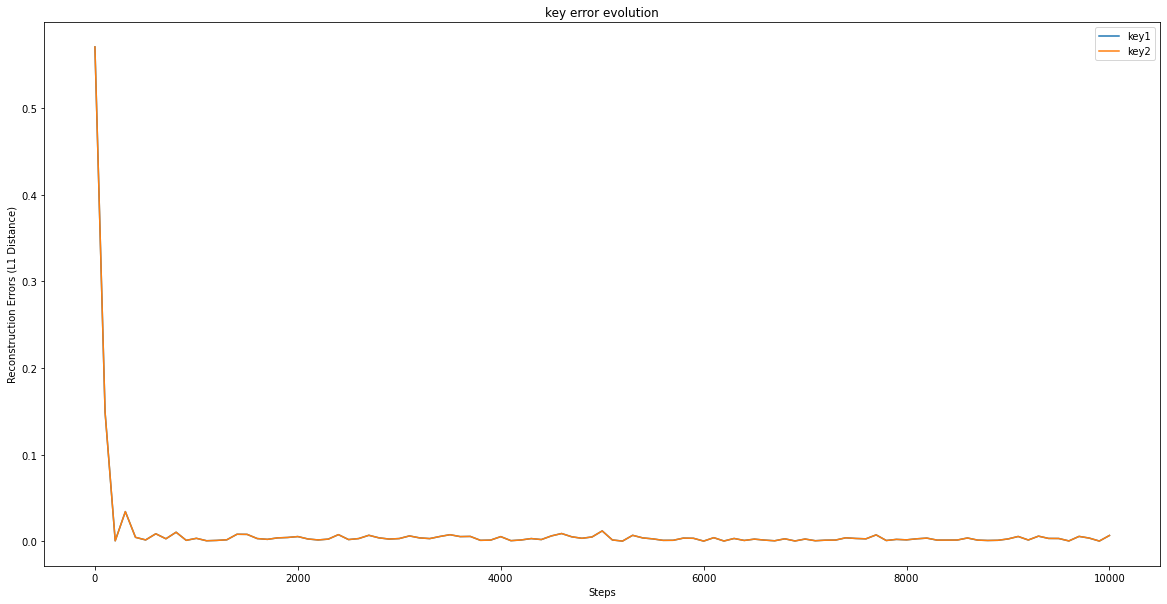

In [14]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(losses["step"], losses["key1_error"], label="key1")
ax.plot(losses["step"], losses["key2_error"], label="key2")
ax.legend()
ax.set_title("key error evolution")
ax.set_xlabel("Steps")
ax.set_ylabel("Reconstruction Errors (L1 Distance)")

plt.show()

In [107]:
def generate_single_data(gpu_available, batch_size, n):
    if gpu_available:
        return torch.randint(0, 2, (batch_size, n), dtype=torch.float).cuda()*2-1
    else:
        return torch.randint(0, 2, (batch_size, n), dtype=torch.float)*2-1
# end

In [153]:
batch_size = 256
n = 16
learning_rate = 0.0008
training_steps = 15000
gpu_available = True
show_every_n_steps = 100
aggregated_losses_every_n_steps = 100
clip_value = 1
h = 4 #hidden layer neuron count
i = 4 # input per h
wr = 5 # weight range

alice_key = TreeParityMachine(h, i, wr)
bob_key = TreeParityMachine(h,i,wr)

alice = MixTransformNN(D_in=(n*2), H=(n*2))
bob = MixTransformNN(D_in=(n*2), H=(n*2))
eve = MixTransformNN(D_in=(n), H=(n*2))

alice.train()
bob.train()
eve.train()
alice.cuda()
bob.cuda()
eve.cuda()

aggregated_losses = {
            "key_weight_diff": [],
            "alice_bob_training_loss": [],
            "bob_reconstruction_training_errors": [],
            "eve_reconstruction_training_errors": [],
            "step": []
}

optimizer_alice = Adam(params=alice.parameters(), lr=learning_rate)
optimizer_bob = Adam(params=bob.parameters(), lr=learning_rate)
optimizer_eve = Adam(params=eve.parameters(), lr=learning_rate)

bob_reconstruction_error = nn.L1Loss()
eve_reconstruction_error = nn.L1Loss()

step_score = 1
updates = 0

for step in range(training_steps+1):

    # Training alternates between Alice/Bob and Eve
    for network, num_minibatches in {"alice_bob": 2, "eve": 1}.items():

        """ 
        Alice/Bob training for one minibatch, and then Eve training for two minibatches this ratio 
        in order to give a slight computational edge to the adversary Eve without training it so much
        that it becomes excessively specific to the exact current parameters of Alice and Bob
        """
        for minibatch in range(num_minibatches):

            p = generate_single_data(gpu_available=True, batch_size=batch_size, n=n)
            
            ka = np.reshape(alice_key.weights, (-1, n))
            ka = np.tile(ka, (batch_size, 1))
            ka = torch.tensor(ka).cuda()
            ka = ka.float()
            
            kb = np.reshape(bob_key.weights, (-1, n))
            kb = np.tile(kb, (batch_size, 1))
            kb = torch.tensor(kb).cuda()
            kb = kb.float()

            # forward pass through alice and eve networks
            alice_c = alice.forward(torch.cat((p, ka), 1).float())
            #print(alice_c)
            eve_p = eve.forward(alice_c)

            if network == "alice_bob":

                # forward pass through bob network
                bob_p = bob.forward(torch.cat((alice_c, ka), 1).float())
                
                #print(bob_p)

                # calculate errors
                error_bob = bob_reconstruction_error(input=bob_p, target=p)
                error_eve = eve_reconstruction_error(input=eve_p, target=p)
                alice_bob_loss =  error_bob + (1.0 - error_eve**2)

                # Zero gradients, perform a backward pass, clip gradients, and update the weights.
                optimizer_alice.zero_grad()
                optimizer_bob.zero_grad()
                alice_bob_loss.backward()
                nn.utils.clip_grad_value_(alice.parameters(), clip_value)
                nn.utils.clip_grad_value_(bob.parameters(), clip_value)
                optimizer_alice.step()
                optimizer_bob.step()
                
                if (step_score != 0):
                    for i in range (0, batch_size):
                        alice_key_input = p.cpu().numpy()[i]
                        bob_key_input = bob_p.cpu().detach().numpy()[i]
                        for j in range(len(bob_key_input)):
                            if (bob_key_input[j] < 0):
                                bob_key_input[j] = -1
                            else:
                                bob_key_input[j] = 1
                        tau_alice = alice_key.get_output(alice_key_input)
                        tau_bob = bob_key.get_output(bob_key_input)
                        
                        #print("alice:", alice_key_input, "bob:", bob_key_input)
                        if (tau_bob == tau_alice): 
                            alice_key.update(tau_bob)
                            bob_key.update(tau_alice)
                            updates += 1

                        step_score = weight_diff(alice_key, bob_key)
                        #print ("key_weight_diff:", step_score)
                        if (step_score == 0):
                            print("broken")
                            break
                        aggregated_losses["key_weight_diff"].append(step_score)
                        
                        if ((i % 50) == 0 and step % 50 == 0):
                            print("weight diff:", step_score)
                            
                        if ((i % 100) == 0 and step % 50 == 0):
                            print("update count:", updates)
                            print("alice tau:", tau_alice)
                            print("bob tau:", tau_bob)
                            print("alice WEIGHT:", alice_key.weights)
                            print("bob weights:", bob_key.weights)
                

            elif network == "eve":

                # calculate error
                error_eve = eve_reconstruction_error(input=eve_p, target=p)

                # Zero gradients, perform a backward pass, and update the weights
                optimizer_eve.zero_grad()
                error_eve.backward()
                nn.utils.clip_grad_value_(eve.parameters(), clip_value)
                optimizer_eve.step()


    if step % aggregated_losses_every_n_steps == 0:
        # aggregate min training errors for bob and eve networks
        aggregated_losses["alice_bob_training_loss"].append(alice_bob_loss.cpu().detach().numpy().tolist())
        aggregated_losses["bob_reconstruction_training_errors"].append(error_bob.cpu().detach().numpy().tolist())
        aggregated_losses["eve_reconstruction_training_errors"].append(error_eve.cpu().detach().numpy().tolist())
        aggregated_losses["step"].append(step)

    if step % show_every_n_steps == 0:
        print("Total_Steps: %i of %i || Bob_Alice_Loss: %.5f || Bob_Reconstruction_Error: %.5f || Eve_Reconstruction_Error: %.5f || key_diff %.5f" % (step, training_steps, 
                                                                                                                                     aggregated_losses["alice_bob_training_loss"][-1], 
                                                                                                                                     aggregated_losses["bob_reconstruction_training_errors"][-1], 
                                                                                                                                aggregated_losses["eve_reconstruction_training_errors"][-1],
                                                                                                                                    aggregated_losses["key_weight_diff"][-1]))
        

weight diff: 63
update count: 0
alice tau: 0.0
bob tau: -1.0
alice WEIGHT: [[ 5  0  3 -1]
 [-4 -2  4 -5]
 [ 2 -4 -2  2]
 [-2  2  5  5]]
bob weights: [[-3  4  5  3]
 [ 2 -1  1 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 71
weight diff: 77
update count: 36
alice tau: 1.0
bob tau: -1.0
alice WEIGHT: [[ 5 -3  5  0]
 [-4  5  5 -5]
 [ 5 -5 -5 -2]
 [-4  2  5  5]]
bob weights: [[-3  4  5  3]
 [-5 -5 -5 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 83
weight diff: 88
update count: 77
alice tau: -1.0
bob tau: -1.0
alice WEIGHT: [[ 3 -5  5 -2]
 [-1  5  5 -1]
 [ 5 -5 -5 -1]
 [-5  2  5  5]]
bob weights: [[-3  4  5  3]
 [-5 -5 -5 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 82
weight diff: 77
update count: 96
alice tau: -1.0
bob tau: -1.0
alice WEIGHT: [[ 5 -5  5  4]
 [-3  2  5 -5]
 [ 3 -5 -5  0]
 [-5  5  3  5]]
bob weights: [[-3  4  5  3]
 [-5 -5 -5 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 76
weight diff: 87
update count: 134
alice tau: 1.0
bob tau: -1.0
alice WEIGHT: [[ 5 -5  2  4]

weight diff: 95
weight diff: 74
update count: 51246
alice tau: 1.0
bob tau: -1.0
alice WEIGHT: [[ 4 -3  5  5]
 [ 3  1  3  5]
 [ 5 -4  3 -5]
 [-5 -3  2  4]]
bob weights: [[-3  4  5  3]
 [-5 -5 -5 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 82
weight diff: 95
update count: 51288
alice tau: 0.0
bob tau: -1.0
alice WEIGHT: [[ 5 -5  3 -1]
 [ 5  5  4  5]
 [ 5  3  5 -5]
 [-3 -3 -5  5]]
bob weights: [[-3  4  5  3]
 [-5 -5 -5 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 86
weight diff: 66
update count: 61315
alice tau: 0.0
bob tau: -1.0
alice WEIGHT: [[-5 -5  4  5]
 [ 4  4 -5 -5]
 [-4  5 -5  0]
 [-5 -4  3 -3]]
bob weights: [[-3  4  5  3]
 [-5 -5 -5 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 60
weight diff: 65
update count: 61356
alice tau: -1.0
bob tau: -1.0
alice WEIGHT: [[-5  0  4  5]
 [ 4  5 -5 -5]
 [-5  4 -5 -2]
 [-4 -5  1  4]]
bob weights: [[-3  4  5  3]
 [-5 -5 -5 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 84
weight diff: 86
update count: 61399
alice tau: -0.0
bob tau: -1

weight diff: 55
weight diff: 53
update count: 112516
alice tau: 1.0
bob tau: -1.0
alice WEIGHT: [[ 3  4 -5  5]
 [-4 -5  5 -5]
 [ 5 -3  5  2]
 [ 4  4  3 -5]]
bob weights: [[-3  4  5  3]
 [-5 -5 -5 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 48
weight diff: 53
update count: 112537
alice tau: 0.0
bob tau: -1.0
alice WEIGHT: [[ 3  5 -5  4]
 [-5 -4  5 -5]
 [ 4 -5  5 -3]
 [ 5  5  5 -5]]
bob weights: [[-3  4  5  3]
 [-5 -5 -5 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 54
weight diff: 57
update count: 112580
alice tau: -1.0
bob tau: -1.0
alice WEIGHT: [[ 3  4 -4  5]
 [-4 -5  4 -5]
 [-5 -3  5 -5]
 [ 5  4  5 -5]]
bob weights: [[-3  4  5  3]
 [-5 -5 -5 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 52
weight diff: 53
update count: 112615
alice tau: 0.0
bob tau: -1.0
alice WEIGHT: [[ 4  5 -2  5]
 [-3 -5  3 -5]
 [-4  0  5 -4]
 [ 5  5  5 -5]]
bob weights: [[-3  4  5  3]
 [-5 -5 -5 -5]
 [ 3  0  2 -2]
 [ 5 -3  2 -2]]
weight diff: 62
weight diff: 66
update count: 122722
alice tau: 1.0
bob tau

weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGH

weight diff: 26
Total_Steps: 1100 of 15000 || Bob_Alice_Loss: 0.40676 || Bob_Reconstruction_Error: 0.18786 || Eve_Reconstruction_Error: 0.88371 || key_diff 26.00000
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]


weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGH

weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
Total_Steps: 1700 of 15000 || Bob_Alice_Loss: 0.06266 || Bob_Reconstruction_Error: 0.03621 || Eve_Reconstruction_Error: 0.98947 || key_diff 26.00000
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0

weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
Total_Steps: 2000 of 15000 || Bob_Alice_Loss: 0.06551 || Bob_Reconstruction_Error: 0.02918 || Eve_Reconstruction_Error: 0.98266 || key_diff 26.00000
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob

weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
Total_Steps: 2300 of 15000 || Bob_Alice_Loss: 0.07408 || Bob_Reconstruction_Error: 0.02419 || Eve_Reconstruction_Error: 0.98048 || key_diff 26.00000
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
b

weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
Total_Steps: 2600 of 15000 || Bob_Alice_Loss: 0.06139 || Bob_Reconstruction_Error: 0.01739 || Eve_Reconstruction_Error: 0.97157 || key_diff 26.00000
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 

weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEI

weight diff: 26
Total_Steps: 3200 of 15000 || Bob_Alice_Loss: 0.11942 || Bob_Reconstruction_Error: 0.03169 || Eve_Reconstruction_Error: 0.95619 || key_diff 26.00000
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bo

weight diff: 26
Total_Steps: 3500 of 15000 || Bob_Alice_Loss: 0.15699 || Bob_Reconstruction_Error: 0.03306 || Eve_Reconstruction_Error: 0.93624 || key_diff 26.00000
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]


weight diff: 26
Total_Steps: 3800 of 15000 || Bob_Alice_Loss: 0.17602 || Bob_Reconstruction_Error: 0.03305 || Eve_Reconstruction_Error: 0.92945 || key_diff 26.00000
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bo

weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
Total_Steps: 4100 of 15000 || Bob_Alice_Loss: 0.22222 || Bob_Reconstruction_Error: 0.05757 || Eve_Reconstruction_Error: 0.90793 || key_diff 26.00000
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0 

weight diff: 26
Total_Steps: 4400 of 15000 || Bob_Alice_Loss: 0.23376 || Bob_Reconstruction_Error: 0.03996 || Eve_Reconstruction_Error: 0.91356 || key_diff 26.00000
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
b

weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: -0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
Total_Steps: 4700 of 15000 || Bob_Alice_Loss: 0.22825 || Bob_Reconstruction_Error: 0.03905 || Eve_Reconstruction_Error: 0.91130 || key_diff 26.00000
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: 1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob weights: [[ 0  0  0  0]
 [ 2  0  0  2]
 [-3  3  1  2]
 [ 1  4 -3 -3]]
weight diff: 26
weight diff: 26
update count: 148347
alice tau: -1.0
bob tau: 0.0
alice WEIGHT: [[ 1 -1  3 -2]
 [ 2 -2  2  1]
 [-3  3 -2  5]
 [ 3  3 -1  0]]
bob

KeyboardInterrupt: 

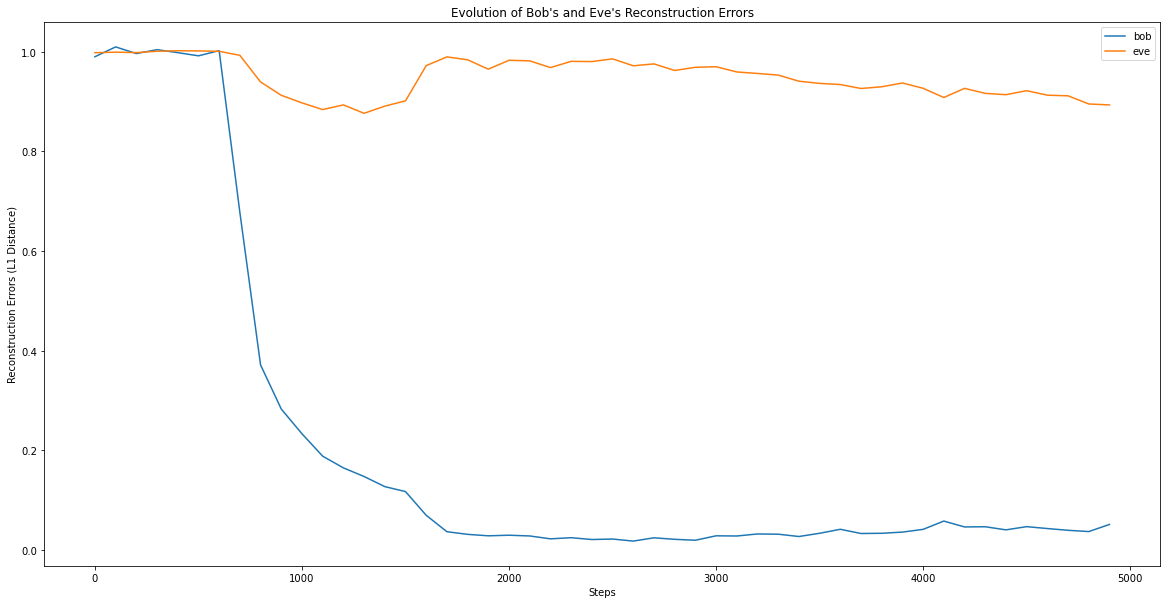

In [155]:

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(aggregated_losses["step"], aggregated_losses["bob_reconstruction_training_errors"], label="bob")
ax.plot(aggregated_losses["step"], aggregated_losses["eve_reconstruction_training_errors"], label="eve")
ax.legend()
ax.set_title("Evolution of Bob's and Eve's Reconstruction Errors")
ax.set_xlabel("Steps")
ax.set_ylabel("Reconstruction Errors (L1 Distance)")

plt.show()

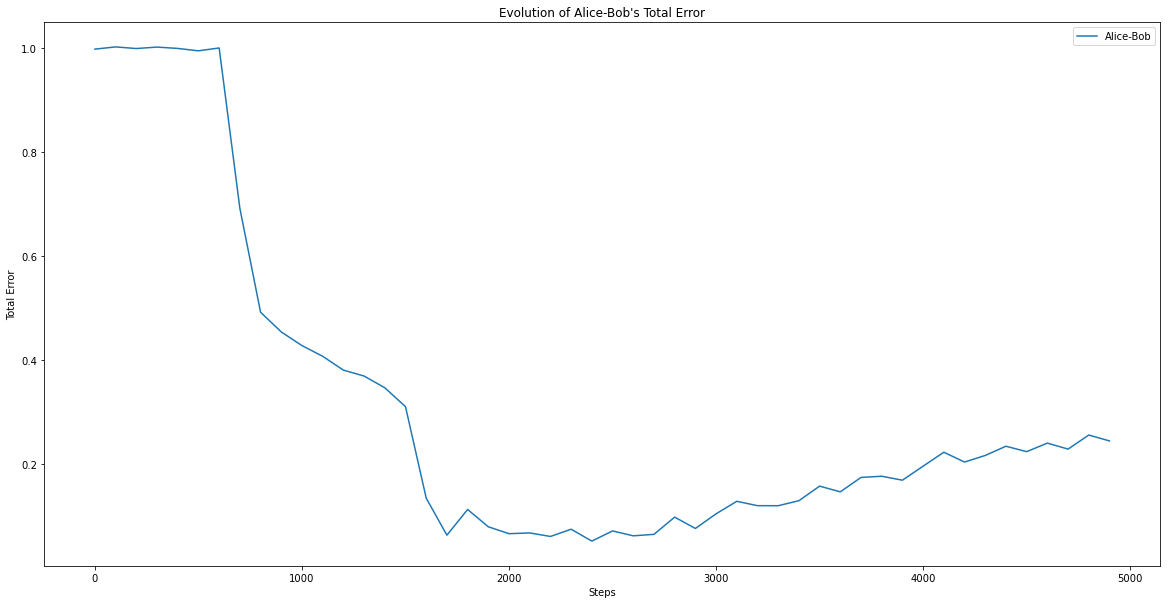

In [156]:

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(aggregated_losses["step"], aggregated_losses["alice_bob_training_loss"], label="Alice-Bob")
ax.legend()
ax.set_title("Evolution of Alice-Bob's Total Error")
ax.set_xlabel("Steps")
ax.set_ylabel("Total Error")

plt.show()

ValueError: x and y must have same first dimension, but have shapes (35,) and (1789184,)

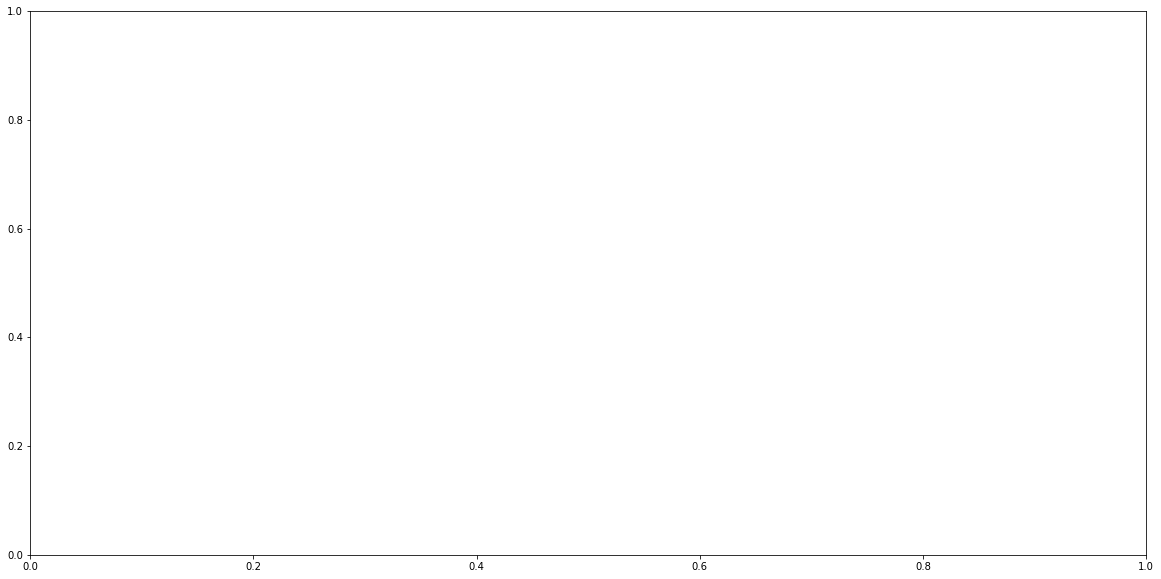

In [137]:

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(aggregated_losses["step"], aggregated_losses["key_weight_diff"], label="keys")
ax.legend()
ax.set_title("Evolution of key weights")
ax.set_xlabel("Steps")
ax.set_ylabel("Weight Difference")

plt.show()

In [130]:
def equals(in1, in2):
    return 1 if in1 == in2 else 0

class TreeParityMachine:
    def __init__(self, hidden_neur=3, input_size=4, weight_range=6):
        self.hidden_neur = hidden_neur
        self.input_size = input_size
        self.weight_range = weight_range
        self.weights = np.random.randint(-weight_range, weight_range + 1, [hidden_neur, input_size])
        
    def get_output(self, input_vector):
        hidden_neur = self.hidden_neur
        input_size = self.input_size
        weights = self.weights
        
        input_vector = input_vector.reshape([hidden_neur, input_size])
        
        sigma = np.sign(np.sum(input_vector * weights, axis=1))
        tau = np.prod(sigma)
        
        self.input_vector = input_vector
        self.sigma = sigma
        self.tau = tau
                
        return tau
    
    def update(self, tau2):
        tau1 = self.tau
        
        if (tau1 == tau2):
            k, n = self.weights.shape
            for (i, j), _ in np.ndenumerate(self.weights):
                self.weights[i,j] -= self.input_vector[i,j] * equals(self.sigma[i], tau1) * equals(tau1, tau2)
                self.weights[i,j] = np.clip(self.weights[i,j], -self.weight_range, self.weight_range)
 

In [ ]:
alice = TreeParityMachine(h, i, wr)
bob = TreeParityMachine(h,i,wr)

def random():
    return np.random.randint(-wr, wr + 1, [h, i])

def weight_diff(in1, in2):
    #return 1.0 - np.average(1.0 * np.abs(in1.weights, in2.weights)/(2*wr))
    return np.sum(np.abs(in1.weights - in2.weights))

equal = False
update_count = 0
diffs = []
 
while (not equal):
    
    rand_in = random()
    tau_alice = alice.get_output(rand_in)
    tau_bob = bob.get_output(rand_in)
    
    alice.update(tau_bob)
    bob.update(tau_alice)
    
    update_count += 1
     
    step_score = weight_diff(alice, bob)
    diffs.append(step_score)
    print("score:", step_score, " update:", update_count)
    
    if (step_score == 0):
        equal = True
        print("A:", alice.weights)
        print("B:", bob.weights)
        
import matplotlib.pyplot as mpl
mpl.plot(diffs)
mpl.show()  

tensor([[-1., -1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,
          1., -1.],
        [-1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
         -1., -1.]], device='cuda:0')
[-1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1. -1. -1.  1.  1. -1.]


In [145]:
print (10 % 100)

10
